# Loading our data in train and test mode

In [ ]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


Extracting /F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /F_MNIST_data/FashionMNIST/raw



Extracting /F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /F_MNIST_data/FashionMNIST/raw



Extracting /F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /F_MNIST_data/FashionMNIST/raw



Extracting /F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /F_MNIST_data/FashionMNIST/raw
Processing...
Done!


#Creation of our model 

In [ ]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

#  Forward pass with one batch from the test set

In [ ]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


# Using the ps.topk method to get the most likely class

In [ ]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[3],
        [3],
        [3],
        [3],
        [9],
        [3],
        [3],
        [3],
        [3],
        [3]])


# Check if the predicted classes match the labels

In [ ]:
equals = top_class == labels.view(*top_class.shape)

# Calculate the percentage of correct predictions

In [ ]:
# The network is untrained so it's making random guesses and we should see an accuracy around 10%
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 10.9375%


#Train our model with a validation pass to see how well it performing on  a test set

In [ ]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.511..  Test Loss: 0.453..  Test Accuracy: 0.834
Epoch: 2/30..  Training Loss: 0.391..  Test Loss: 0.410..  Test Accuracy: 0.857
Epoch: 3/30..  Training Loss: 0.355..  Test Loss: 0.370..  Test Accuracy: 0.866
Epoch: 4/30..  Training Loss: 0.334..  Test Loss: 0.383..  Test Accuracy: 0.867
Epoch: 5/30..  Training Loss: 0.315..  Test Loss: 0.374..  Test Accuracy: 0.867
Epoch: 6/30..  Training Loss: 0.301..  Test Loss: 0.370..  Test Accuracy: 0.870
Epoch: 7/30..  Training Loss: 0.292..  Test Loss: 0.371..  Test Accuracy: 0.873
Epoch: 8/30..  Training Loss: 0.281..  Test Loss: 0.368..  Test Accuracy: 0.871
Epoch: 9/30..  Training Loss: 0.272..  Test Loss: 0.363..  Test Accuracy: 0.877
Epoch: 10/30..  Training Loss: 0.268..  Test Loss: 0.366..  Test Accuracy: 0.878
Epoch: 11/30..  Training Loss: 0.261..  Test Loss: 0.388..  Test Accuracy: 0.869
Epoch: 12/30..  Training Loss: 0.254..  Test Loss: 0.365..  Test Accuracy: 0.879
Epoch: 13/30..  Training Loss: 0.249.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

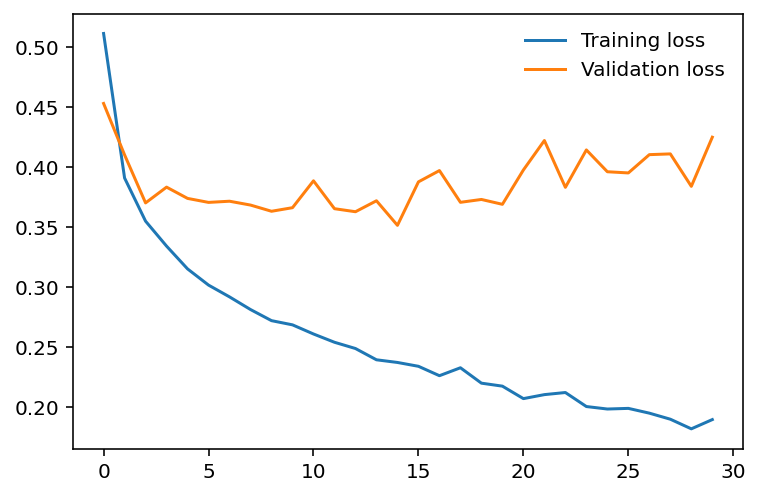

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

# Overfitting problem

# Building a model with dropout method(train mode)

In [4]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x


Extracting /F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /F_MNIST_data/FashionMNIST/raw



Extracting /F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /F_MNIST_data/FashionMNIST/raw



Extracting /F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /F_MNIST_data/FashionMNIST/raw



Extracting /F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /F_MNIST_data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.610..  Test Loss: 0.529..  Test Accuracy: 0.812
Epoch: 2/30..  Training Loss: 0.487..  Test Loss: 0.418..  Test Accuracy: 0.851
Epoch: 3/30..  Training Loss: 0.455..  Test Loss: 0.410..  Test Accuracy: 0.851
Epoch: 4/30..  Training Loss: 0.431..  Test Loss: 0.399..  Test Accuracy: 0.863
Epoch: 5/30..  Training Loss: 0.426..  Test Loss: 0.421..  Test Accuracy: 0.851
Epoch: 6/30..  Training Loss: 0.410..  Test Loss: 0.411..  Test Accuracy: 0.852
Epoch: 7/30..  Training Loss: 0.404..  Test Loss: 0.394..  Test Accuracy: 0.864
Epoch: 8/30..  Training Loss: 0.400..  Test Loss: 0.380..  Test Accuracy: 0.870
Epoch: 9/30..  Training Loss: 0.392..  Test Loss: 0.374..  Test Accuracy: 0.869
Epoch: 10/30..  Training Loss: 0.387..  Test Loss: 0.407..  Test Accuracy: 0.854
Epoch: 11/30..  Training Loss: 0.380..  Test Loss: 0.390..  Test Accuracy: 0.864
Epoch: 12/30..  Training Loss: 0.375..  Test Loss: 0.389..  Test Accuracy: 0.865
Epoch: 13/30..  Training Loss: 0.374.

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

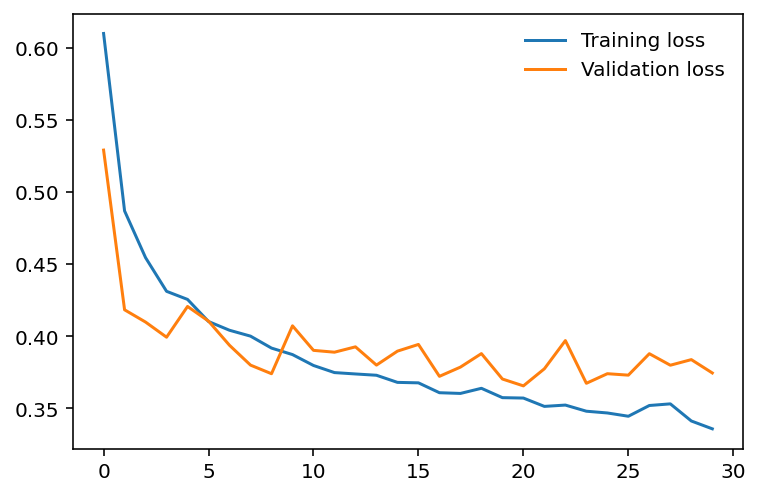

In [7]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

# Inference (validation mode)

In [8]:
#download the custom helper.py file
!wget https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/3bd7dea850e936d8cb44adda8200e4e2b5d627e3/intro-to-pytorch/helper.py

--2021-03-18 03:01:53--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/3bd7dea850e936d8cb44adda8200e4e2b5d627e3/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2813 (2.7K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   2.75K  --.-KB/s    in 0s      

2021-03-18 03:01:53 (49.7 MB/s) - ‘helper.py’ saved [2813/2813]



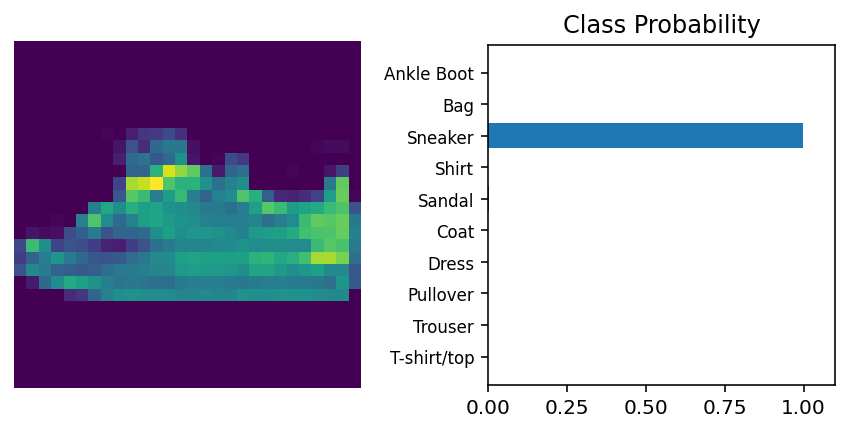

In [9]:
# Import helper module (should be in the repo)
import custom_helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
custom_helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')